In [12]:
from settrade_v2 import Investor
from pprint import pprint
from settrade_v2 import Investor
import psycopg2
import pandas as pd
import time
from psycopg2 import sql
from datetime import datetime
from pprint import pprint
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np

In [13]:
investor = Investor(
                    app_id="Sv9aL4wQgqe5QWIc",
                    app_secret="ctvHfPhpVg+xQDFWDXgGqCIPbmHIPrduOnhbNzEL0tc=",
                    broker_id="SANDBOX",
                    app_code="SANDBOX",
                    is_auto_queue = False)

In [14]:
# กรณี Investor
market = investor.MarketData()

In [15]:
mkt_data = investor.MarketData()
res = mkt_data.get_quote_symbol("AOT")
pprint(res)

{'aumSize': None,
 'average': 52.0,
 'change': 11.25,
 'eps': 0.37,
 'exchange': None,
 'exercisePrice': None,
 'exerciseRatio': None,
 'high': 52.0,
 'impliedVolatility': None,
 'inav': None,
 'instrumentType': 'STOCK',
 'intrinsicValue': None,
 'last': 52.0,
 'lastTradingDate': None,
 'low': 52.0,
 'marketStatus': 'Open1',
 'maturityDate': None,
 'moneyness': None,
 'pbv': 4.39,
 'pe': 28.44,
 'percentChange': 27.61,
 'percentYield': 1.9900000095367432,
 'securityType': 'CS',
 'status': '',
 'symbol': 'AOT',
 'theoretical': None,
 'toLastTrade': None,
 'totalBuyVolume': 0,
 'totalNoSideVolume': 100,
 'totalSellVolume': 0,
 'totalVolume': 100,
 'underlying': None,
 'underlyingPrice': None}


In [20]:
db_config = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'fateehah5329',
    'host': 'localhost',
    'port': "5432"
}

In [21]:
# ✅ ฟังก์ชันสร้างตาราง
def create_table():
    create_table_query = """
    CREATE TABLE IF NOT EXISTS stock_financials (
        symbol TEXT PRIMARY KEY,
        instrument_type TEXT DEFAULT 'STOCK',
        security_type TEXT DEFAULT 'CS',
        market_status TEXT DEFAULT 'Unknown',
        total_volume INT DEFAULT 0,
        aum_size NUMERIC DEFAULT 0,
        average NUMERIC DEFAULT 0,
        change NUMERIC DEFAULT 0,
        eps NUMERIC DEFAULT 0,
        exchange TEXT DEFAULT '',
        exercise_price NUMERIC DEFAULT 0,
        exercise_ratio NUMERIC DEFAULT 0,
        high NUMERIC DEFAULT 0,
        implied_volatility NUMERIC DEFAULT 0,
        inav NUMERIC DEFAULT 0,
        intrinsic_value NUMERIC DEFAULT 0,
        last NUMERIC DEFAULT 0,
        last_trading_date DATE,
        low NUMERIC DEFAULT 0,
        maturity_date DATE,
        moneyness NUMERIC DEFAULT 0,
        pbv NUMERIC DEFAULT 0,
        pe NUMERIC DEFAULT 0,
        percent_change NUMERIC DEFAULT 0,
        percent_yield NUMERIC DEFAULT 0,
        theoretical NUMERIC DEFAULT 0,
        to_last_trade NUMERIC DEFAULT 0,
        underlying TEXT DEFAULT '',
        underlying_price NUMERIC DEFAULT 0,
        updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """
    try:
        # 🔗 เชื่อมต่อฐานข้อมูล
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cursor:
                cursor.execute(create_table_query)
                conn.commit()
        print("✅ ตาราง `stock_financials` ถูกสร้างหรือมีอยู่แล้ว!")
    except Exception as e:
        print("❌ Error creating table:", e)

# ✅ รันฟังก์ชันสร้างตาราง
create_table()

✅ ตาราง `stock_financials` ถูกสร้างหรือมีอยู่แล้ว!


In [23]:
import os
import time
import psycopg2
import pandas as pd
from settrade_v2 import Investor
from dotenv import load_dotenv

# ✅ โหลดตัวแปรจาก .env
load_dotenv()


# ✅ สร้าง Object สำหรับ Market Data
market = investor.MarketData()

# ✅ ฟังก์ชันดึงข้อมูล Financial Data และบันทึกลง PostgreSQL
def insert_financial_data(symbol):
    try:
        print(f"🔍 กำลังดึงข้อมูล Financial Data สำหรับ {symbol}...")
        
        # ✅ ดึงข้อมูลจาก Settrade API
        res = market.get_quote_symbol(symbol)  # 🔥 เปลี่ยนจาก get_quote() เป็น get_quote_symbol()

        # 🚨 ถ้าไม่มีข้อมูล ให้ข้าม
        if not isinstance(res, dict) or "symbol" not in res:
            print(f"⚠️ ไม่มีข้อมูลสำหรับ {symbol}.")
            return

        # 🔧 กำหนดค่าเริ่มต้นหากไม่มีข้อมูล
        data = {
            'symbol': res.get('symbol', symbol),
            'instrument_type': res.get('instrumentType', 'STOCK'),
            'security_type': res.get('securityType', 'CS'),
            'market_status': res.get('marketStatus', 'Unknown'),
            'total_volume': res.get('totalVolume', 0),
            'aum_size': res.get('aumSize', 0),
            'average': res.get('average', 0),
            'change': res.get('change', 0),
            'eps': res.get('eps', 0),
            'exchange': res.get('exchange', ''),
            'exercise_price': res.get('exercisePrice', 0),
            'exercise_ratio': res.get('exerciseRatio', 0),
            'high': res.get('high', 0),
            'implied_volatility': res.get('impliedVolatility', 0),
            'inav': res.get('inav', 0),
            'intrinsic_value': res.get('intrinsicValue', 0),
            'last': res.get('last', 0),
            'last_trading_date': res.get('lastTradingDate', None),
            'low': res.get('low', 0),
            'maturity_date': res.get('maturityDate', None),
            'moneyness': res.get('moneyness', 0),
            'pbv': res.get('pbv', 0),
            'pe': res.get('pe', 0),
            'percent_change': res.get('percentChange', 0),
            'percent_yield': res.get('percentYield', 0),
            'theoretical': res.get('theoretical', 0),
            'to_last_trade': res.get('toLastTrade', 0),
            'underlying': res.get('underlying', ''),
            'underlying_price': res.get('underlyingPrice', 0)
        }

        # ✅ เชื่อมต่อฐานข้อมูลและบันทึกข้อมูล
        with psycopg2.connect(**db_config) as conn:
            with conn.cursor() as cursor:
                insert_query = """
                    INSERT INTO stock_financials (
                        symbol, instrument_type, security_type, market_status, total_volume, 
                        aum_size, average, change, eps, exchange, exercise_price, 
                        exercise_ratio, high, implied_volatility, inav, intrinsic_value, 
                        last, last_trading_date, low, maturity_date, moneyness, pbv, pe, 
                        percent_change, percent_yield, theoretical, to_last_trade, underlying, 
                        underlying_price, updated_at
                    ) VALUES (
                        %(symbol)s, %(instrument_type)s, %(security_type)s, %(market_status)s, %(total_volume)s,
                        %(aum_size)s, %(average)s, %(change)s, %(eps)s, %(exchange)s, %(exercise_price)s,
                        %(exercise_ratio)s, %(high)s, %(implied_volatility)s, %(inav)s, %(intrinsic_value)s,
                        %(last)s, %(last_trading_date)s, %(low)s, %(maturity_date)s, %(moneyness)s, %(pbv)s, %(pe)s,
                        %(percent_change)s, %(percent_yield)s, %(theoretical)s, %(to_last_trade)s, %(underlying)s,
                        %(underlying_price)s, NOW()
                    )
                    ON CONFLICT (symbol) DO UPDATE SET
                        last = EXCLUDED.last,
                        change = EXCLUDED.change,
                        percent_change = EXCLUDED.percent_change,
                        high = EXCLUDED.high,
                        low = EXCLUDED.low,
                        total_volume = EXCLUDED.total_volume,
                        updated_at = NOW();
                """
                cursor.execute(insert_query, data)
                conn.commit()
                print(f"✅ ข้อมูล Financial Data ของ {symbol} ถูกบันทึกเรียบร้อยแล้ว!")

    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาดกับ {symbol}: {e}")

# ✅ โหลดรายชื่อหุ้นทั้งหมดจากไฟล์ CSV
try:
    symbols_df = pd.read_csv("/Users/macbook002/Downloads/thai_stocks-1.csv")  # ไฟล์ต้องมีคอลัมน์ 'symbol'
    symbols = symbols_df['symbol'].dropna().tolist()
except FileNotFoundError:
    print("❌ ไม่พบไฟล์ 'thai_stocks.csv' ใช้รายชื่อหุ้นที่กำหนดแทน")
    symbols = ["PTT", "AOT", "SCB", "CPALL", "ADVANC"]

# ✅ ดึงข้อมูล Financial Data สำหรับหุ้นทุกตัว
for symbol in symbols:
    insert_financial_data(symbol)
    time.sleep(2)  # ⏳ ควบคุม API Rate Limit

🔍 กำลังดึงข้อมูล Financial Data สำหรับ 24CS...
✅ ข้อมูล Financial Data ของ 24CS ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ 2S...
✅ ข้อมูล Financial Data ของ 2S ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ 3BBIF...
✅ ข้อมูล Financial Data ของ 3BBIF ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ A...
✅ ข้อมูล Financial Data ของ A ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ A5...
✅ ข้อมูล Financial Data ของ A5 ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ AAI...
✅ ข้อมูล Financial Data ของ AAI ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ AAV...
✅ ข้อมูล Financial Data ของ AAV ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ ABM...
✅ ข้อมูล Financial Data ของ ABM ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ ACAP...
✅ ข้อมูล Financial Data ของ ACAP ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูล Financial Data สำหรับ ACC...
✅ ข้อมูล Financial Data ของ ACC ถูกบ

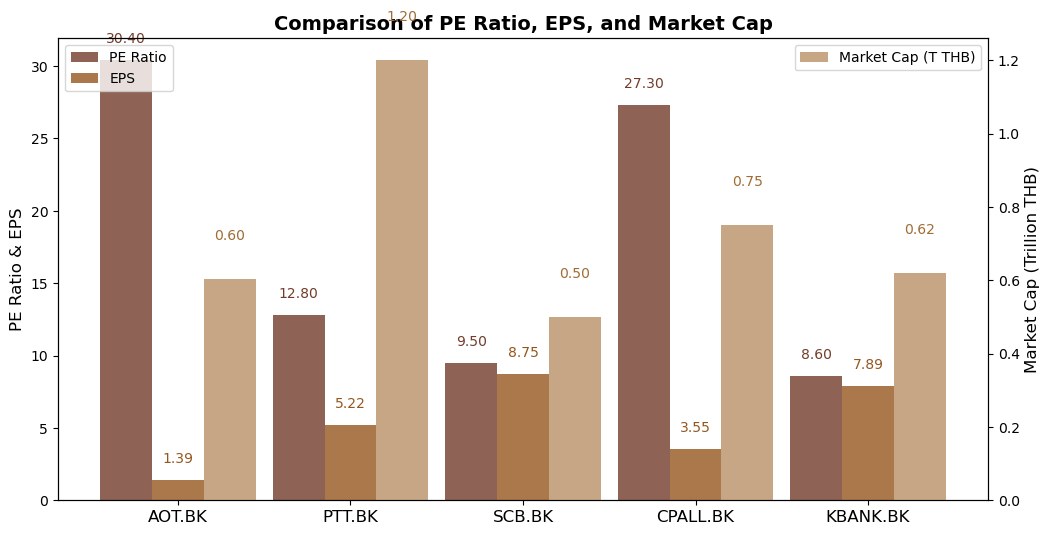

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ✅ ข้อมูลหุ้นตัวอย่าง
data = {
    "symbol": ["AOT.BK", "PTT.BK", "SCB.BK", "CPALL.BK", "KBANK.BK"],
    "PE Ratio": [30.4, 12.8, 9.5, 27.3, 8.6],
    "EPS": [1.39, 5.22, 8.75, 3.55, 7.89],
    "Market Cap": [603570831360, 1200000000000, 500000000000, 750000000000, 620000000000],
}

df_viz = pd.DataFrame(data)

# ✅ กำหนดตำแหน่งของหุ้น
fig, ax1 = plt.subplots(figsize=(12, 6))
width = 0.3  # ความกว้างของแท่ง
x = np.arange(len(df_viz["symbol"]))

# ✅ สร้าง Secondary Axis สำหรับ Market Cap
ax2 = ax1.twinx()

# ✅ วาดกราฟแท่งพร้อมสีที่กำหนด
bars1 = ax1.bar(x - width, df_viz["PE Ratio"], width, label="PE Ratio", color="#723C2A", alpha=0.8)
bars2 = ax1.bar(x, df_viz["EPS"], width, label="EPS", color="#95561E", alpha=0.8)
bars3 = ax2.bar(x + width, df_viz["Market Cap"] / 1e12, width, label="Market Cap (T THB)", color="#A16B34", alpha=0.6)

# ✅ ตั้งค่ากราฟ
ax1.set_xticks(x)
ax1.set_xticklabels(df_viz["symbol"], fontsize=12)
ax1.set_ylabel("PE Ratio & EPS", fontsize=12, color="black")
ax2.set_ylabel("Market Cap (Trillion THB)", fontsize=12, color="black")
ax1.set_title("Comparison of PE Ratio, EPS, and Market Cap", fontsize=14, fontweight="bold")

# ✅ แสดงค่าตัวเลขบนกราฟแท่ง
def add_value_labels(ax, bars, offset=1, color="black"):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + offset, f"{height:.2f}", ha="center", va="bottom", fontsize=10, color=color)

add_value_labels(ax1, bars1, offset=1, color="#723C2A")
add_value_labels(ax1, bars2, offset=1, color="#95561E")
add_value_labels(ax2, bars3, offset=0.1, color="#A16B34")

# ✅ รวม Legend
ax1.legend(loc="upper left", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)

# ✅ แสดงกราฟ
plt.show()
